In [141]:
using RobotZoo
using RobotDynamics
using LinearAlgebra
using StaticArrays
using SparseArrays
using MeshCat, GeometryBasics, Colors, CoordinateTransformations, Rotations
using Plots
using Convex
using SCS

In [122]:
const RD = RobotDynamics

RobotDynamics

In [123]:
function defcolor(c1, c2, c1def, c2def)
    if !isnothing(c1) && isnothing(c2)
        c2 = c1
    else
        c1 = isnothing(c1) ? c1def : c1
        c2 = isnothing(c2) ? c2def : c2
    end
    c1,c2
end

function set_mesh!(vis0, model::RobotZoo.Pendulum; 
    color=nothing, color2=nothing)
    
    vis = vis0["robot"]
    dim = Vec(0.1, 0.3, 0.1)
    cart = Rect3D(-dim/2, dim)
    hinge = Cylinder(Point3f0(-dim[1]/2,0,dim[3]/2), Point3f0(dim[1],0,dim[3]/2), 0.03f0)
    c1,c2 = defcolor(color,color2, colorant"blue", colorant"red")

    pole = Cylinder(Point3f0(0,0,0),Point3f0(0,0,model.len),0.01f0)
    mass = HyperSphere(Point3f0(0,0,model.len), 0.05f0)
    setobject!(vis["cart","box"],   cart, MeshPhongMaterial(color=isnothing(color) ? colorant"green" : color))
    setobject!(vis["cart","hinge"], hinge, MeshPhongMaterial(color=colorant"black"))
    setobject!(vis["cart","pole","geom","cyl"], pole, MeshPhongMaterial(color=c1))
    setobject!(vis["cart","pole","geom","mass"], mass, MeshPhongMaterial(color=c2))
    settransform!(vis["cart","pole"], Translation(0.75*dim[1],0,dim[3]/2))
end

function visualize_state!(vis, model::RobotZoo.Pendulum, x)
    θ = x[1]
    q = expm((pi-θ) * @SVector [1,0,0])
    settransform!(vis["robot","cart","pole","geom"], LinearMap(UnitQuaternion(q)))
end

function visualize!(vis, model::RobotDynamics.AbstractModel, tf::Real, X)
    fps = Int(round((length(X)-1)/tf))
    anim = MeshCat.Animation(fps)
    n = state_dim(model)
    for (k,x) in enumerate(X)
        atframe(anim, k) do
            x = X[k]
            visualize_state!(vis, model, SVector{n}(x)) 
        end
    end
    setanimation!(vis, anim)
end

visualize! (generic function with 1 method)

In [124]:
function create_U(num_knots, m, U_type::String)

    if U_type == "constant"
        u0 = 2 .* ones(m)
    elseif U_type == "random"
        u0 = 0.01 .* ones(m)
    end

    U = [u0]

    for k in 1:(num_knots-1)

        if U_type == "constant"
            u = 2 .* ones(m)
        elseif U_type == "random"
            u = -5 .+ (10*rand(Float64, m))
        end

        push!(U, u)

    end
    
    return U

end

create_U (generic function with 1 method)

In [125]:
function create_training_U(num_knots, m)

    u0 = -3 .* ones(m)
    U = [u0]

    for k in 1:(num_knots-1)

        u = -3 .+ (6*rand(Float64, m))
        push!(U, u)

    end

    # for k in (Int(round((num_knots-1)/2) + 1)) : (num_knots - 1)

    #     u = 2 .* ones(m)
    #     push!(U, u)
    # end
    
    # return U

    # for k in 1 : (Int(round((num_knots-1)/2)))

    #     u = -3 .+ (6*rand(Float64, m))
    #     push!(U, u)

    # end

    # for k in (Int(round((num_knots-1)/2) + 1)) : (num_knots - 1)

    #     u = -2 .* ones(m)
    #     push!(U, u)
    # end
    
    return U

end

create_training_U (generic function with 1 method)

In [126]:
function simulate(dmodel, x0, U, dt)

    t = 0.0
    x = x0
    X = [x]
    T = [t]
    
    for k in 1:length(U)

        u = U[k]
        x = RD.discrete_dynamics(dmodel, x, u, t, dt)
        t += dt
        push!(X, x)
        append!(T, t)

    end

    return T, X

end

simulate (generic function with 1 method)

In [127]:
function chebyshev_poly(x, order=0)

    if order == 0
        return []
    end
    
    T0 = ones(length(x))
    T1 = x

    chebyshev = [T0]
    push!(chebyshev, T1)

    for p in 2:order

        next_T = (2 .* x .* chebyshev[p]) - chebyshev[p-1]
        push!(chebyshev, next_T)

    end

    chebyshev = reduce(vcat, chebyshev[3:end])

    return chebyshev
    
end

chebyshev_poly (generic function with 2 methods)

In [128]:
function hermite_poly(x, order=0)

    if order == 0
        return []
    end
    
    T0 = ones(length(x))
    T1 = 2 .* x

    hermite = [T0]
    push!(hermite, T1)

    for p in 2:order

        next_T = (2 .* x .* hermite[p]) - 2 .* p .* hermite[p-1]
        push!(hermite, next_T)

    end

    hermite = reduce(vcat, hermite[3:end])

    return hermite
    
end

hermite_poly (generic function with 2 methods)

In [129]:
function create_mono(x, order=0)

    if order == 0
        return []
    end

    mono_x = [x]
    row_start_ind = ones(length(x))

    for p in 2:order

        prev_row_start_ind = row_start_ind

        mono = x * mono_x[p-1]'
        mono_perm = mono[1, :]
        row_start_ind = [size(mono)[2]]

        for i in 2:size(mono)[1]

            row_start_ind = vcat(row_start_ind, Int(row_start_ind[i-1] - prev_row_start_ind[i-1]))
            non_repeating_mono = mono[i, end-row_start_ind[i]+1:end]
            mono_perm = vcat(mono_perm, non_repeating_mono)

        end

        push!(mono_x, mono_perm)

    end

    mono_x = reduce(vcat, mono_x[2:end])

    return mono_x
    
end

create_mono (generic function with 2 methods)

In [130]:
function koopman_eigenfunctions(X, U, order=5)

    n = length(X[1])
    num_p = 2*n*order
    Z = []
    Zu = []
    
    for k in 1:length(X)
        
        xk = X[k]
        zk = vcat([1], xk, sin.(xk), cos.(xk), chebyshev_poly(xk, order))
        push!(Z, zk)

        if k < length(X)
            uk = U[k]
            zu = vcat(zk, vec(zk*uk'))
            push!(Zu, zu)
        end

    end

return Z, Zu

end

koopman_eigenfunctions (generic function with 2 methods)

In [131]:
function simulate_bilinear(F, C, g, x0, z0, U)
    
    x = x0
    z = z0
    Z = [z]
    X = [x]

    for k in 1:length(U)

        u = U[k]

        z = F * z + (C * z) .* u
        x = g * z

        push!(Z, z)
        push!(X, x)
        
    end

    return X, Z

end

simulate_bilinear (generic function with 1 method)

In [135]:
function regression(Y, X, gamma=0, lambda=0)
    
    (T, K) = (size(X, 1), size(X, 2))

    Q = X'X / T
    c = X'Y / T                   #c'b = Y'X*b

    b = Variable(K)               #define variables to optimize over
    L1 = quadform(b, Q)           #b'Q*b
    L2 = dot(c, b)                #c'b
    L3 = norm(b, 1)               #sum(|b|)
    L4 = sumsquares(b)            #sum(b^2)

    if gamma==0 && lambda==0
        return X \ Y
    end

    if λ > 0
        Sol = minimize(L1 - 2 * L2 + gamma * L3 + lambda * L4)      #u'u/T + γ*sum(|b|) + λ*sum(b^2), where u = Y-Xb
    else
        Sol = minimize(L1 - 2 * L2 + gamma * L3)               #u'u/T + γ*sum(|b|) where u = Y-Xb
    end

    solve!(Sol, SCS.Optimizer; silent_solver = true)
    Sol.status == Convex.MOI.OPTIMAL ? b = vec(evaluate(b)) : b = X \ Y
    
    return b

end

regression (generic function with 3 methods)

In [136]:
# define temporal properties
dt = 0.01
tf = 3

num_knots = Int(tf/dt + 1)

# define pendulum initial properties
x0 = [0.5*pi, 0]

# define Pendulum model
model = RobotZoo.Pendulum()

RobotZoo.Pendulum{Float64, 3}(1.0, 0.5, 0.1, 0.5, 0.25, 9.81, ForwardDiff.JacobianConfig{Nothing, Float64, 3, Tuple{Vector{ForwardDiff.Dual{Nothing, Float64, 3}}, Vector{ForwardDiff.Dual{Nothing, Float64, 3}}}}((Partials(1.0, 0.0, 0.0), Partials(0.0, 1.0, 0.0), Partials(0.0, 0.0, 1.0)), (ForwardDiff.Dual{Nothing, Float64, 3}[Dual{Nothing}(6.9292152105774e-310,6.92921514684137e-310,6.92920107767073e-310,6.9292010776747e-310), Dual{Nothing}(6.92920107767863e-310,6.9292010776826e-310,6.92921614853535e-310,6.92920107768654e-310)], ForwardDiff.Dual{Nothing, Float64, 3}[Dual{Nothing}(6.92919422305376e-310,6.92919422305613e-310,6.9291942230585e-310,6.92919422306087e-310), Dual{Nothing}(6.92919422306324e-310,6.9291942230656e-310,6.929194223068e-310,6.92919422307036e-310), Dual{Nothing}(6.92919422307273e-310,6.92919422307747e-310,6.92919422307984e-310,6.92928833309853e-310)])), FiniteDiff.JacobianCache{Vector{Float64}, Vector{Float64}, Vector{Float64}, UnitRange{Int64}, Nothing, Val{:forward}()

In [137]:
state_dim(model) = 2
control_dim(model) = 1

dmodel = RD.DiscretizedDynamics{RD.RK4}(model)
n, m = RD.dims(dmodel)

# create predefined control trajectory
U_sim = create_training_U(num_knots, m)

# randomly simulate model and store trajectory
time, X_sim = simulate(dmodel, x0, U_sim, dt)

([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.07, 0.08, 0.09  …  2.9199999999999817, 2.9299999999999815, 2.9399999999999813, 2.949999999999981, 2.959999999999981, 2.9699999999999807, 2.9799999999999804, 2.9899999999999802, 2.99999999999998, 3.00999999999998], [[1.5707963267948966, 0.0], [1.569217432789066, -0.31556838125925163], [1.5650080333471623, -0.5261705985355757], [1.558397773244902, -0.7956997703850179], [1.5490133488318296, -1.0809896750541044], [1.5376650769085656, -1.188582793116992], [1.5246243752671245, -1.4193867628452816], [1.5090219410918249, -1.7008848855167975], [1.4909590883757828, -1.9115034608916677], [1.4704848109972595, -2.1831107241395866]  …  [0.6010623802375198, 1.4446401595846425], [0.6144165965980395, 1.2259904080870794], [0.6259740022511553, 1.0852770104896847], [0.6363254344775142, 0.9848031594032179], [0.6450620665142001, 0.7624424574731843], [0.6525472844576706, 0.7344248000184411], [0.6589128884297017, 0.5386615132555694], [0.663840678422

In [138]:
global vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8702
└ @ MeshCat /home/jeonghun/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8702))

In [139]:
visualize!(vis, model, tf, X_sim)

In [140]:
# calculate koopman data matrices
Z_sim, Zu_sim = koopman_eigenfunctions(X_sim, U_sim, 5)

# convert data matrices into actual matrix arrays from vectors of vectors
X_mat = mapreduce(permutedims, vcat, X_sim)'
U_mat = mapreduce(permutedims, vcat, U_sim)'
Z_mat = mapreduce(permutedims, vcat, Z_sim)'
Zu_mat = mapreduce(permutedims, vcat, Zu_sim)'

# extract data matrices
Z = Z_mat[:, 1:end-1]
Z_prime = Z_mat[:, 2:end]
Zu = Zu_mat
X = X_mat[:, 1:end-1]

z0 = Z[:, 1]

num_eigenfunctions = size(Z)[1]

15

In [18]:
# perform ridge regression

# alphaA = 0
# alphag = 0

# gammaA = alphaA .* I(size(Zu')[2])
# regularize_Zu = [Zu' ; gammaA]
# regularize_Z_prime = [Z_prime' ; zeros(size(gammaA)[1], size(Z_prime')[2])]

# gammag = alphag .* I(size(Z')[2])
# regularize_Z = [Z' ; gammag]
# regularize_X = [X' ; zeros(size(gammag)[1], size(X')[2])]

# A = (regularize_Zu \ regularize_Z_prime)'
# g = (regularize_Z \ regularize_X)'

# println(size(g))

# F = A[:, 1:size(A)[1]]
# C = A[:, (size(A)[1] + 1):end]

In [19]:
# perform lasso regression

lambda = 0.01

vec_Z_prime_T = vec(Z_prime')
Zu_T_mat = kron(I(size(Z_prime')[2]), Zu')

vec_X_T = vec(X')
Z_T_mat = kron(I(size(X')[2]), Z')

A_T_vec = Lasso(vec_Z_prime_T, Zu_T_mat, lambda)
g_T_vec = Lasso(vec_X_T, Z_T_mat, 0)

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/jeonghun/.julia/packages/Convex/FQF1R/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/jeonghun/.julia/packages/Convex/FQF1R/src/solution.jl:342


30-element Vector{Float64}:
  8.325314473248045e-14
  1.0000000000017975
  4.206029512686505e-17
 -2.0425939594952615e-12
 -6.292499626772372e-18
 -1.0859712447550066e-13
  8.979637339773824e-17
 -2.497812669734314e-14
 -6.624680370048938e-18
 -8.002675652251114e-14
 -1.0094023870217088e-18
  4.968425617209981e-16
  3.95693887457753e-20
  ⋮
 -4.2893107735570905e-14
 -1.1260466380575826e-16
 -1.8046593432005514e-14
  3.167663004644705e-17
 -4.134625636556586e-15
  1.7447611493527895e-18
 -1.705705087670203e-15
 -3.199315228930149e-18
  7.959586878298297e-17
 -3.947231437611304e-20
  2.5919005795146236e-17
  2.2985406544159002e-20

In [20]:
A = reshape(A_T_vec, size(Zu')[2], size(Z_prime')[2])'
g = reshape(g_T_vec, size(Z')[2], size(X')[2])'

F = A[:, 1:size(A)[1]]
C = A[:, (size(A)[1] + 1):end]

15×15 Matrix{Float64}:
   -2.06346e-7       2.26443e-6  …     1.22919e-9   -2.2352e-14
    0.000175846      0.00160168        8.62486e-7   -8.14444e-12
    0.0325227        0.481186          0.000259126  -2.40895e-9
    0.0802496       -4.92996          -0.00265514    2.39076e-8
    0.372329       103.282             0.0551872    -3.3796e-7
    0.828993         3.11214     …     0.00180034   -2.36594e-7
    5.26603        -54.8782           -0.0298073    -6.14731e-7
   -2.77406        -24.2063           -0.0136625     1.10816e-6
   64.5645         243.803             0.140899     -1.8173e-5
   -3.47218        130.995             0.0706226    -7.3646e-7
  614.849        -3702.9         …    -2.03057      -8.78513e-5
   41.0345        -542.231            -0.296285      4.0005e-6
 5549.47         56252.5              31.6434       -0.0036539
 -116.311          392.169             0.217022     -1.00455e-5
    1.03751e5       -2.40685e5      -139.094        -0.00571772

In [21]:
bi_X, _ = simulate_bilinear(F, C, g, x0, z0, U_sim)
bi_X_mat = mapreduce(permutedims, vcat, bi_X)'

2×302 adjoint(::Matrix{Float64}) with eltype Float64:
 1.5708   1.56922    1.56527    1.55963   …  0.815841  0.840905  0.864244
 0.0     -0.315761  -0.473692  -0.654291     2.55555   2.45675   2.21044

In [22]:
global vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat /home/jeonghun/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8701))

In [23]:
visualize!(vis, model, tf, bi_X)
#visualize!(vis, model, tf, X_sim)

In [24]:
# extract individual state histories
theta_sim = X_mat[1, :]
omega_sim = X_mat[2, :]

theta_bilinear = bi_X_mat[1, :]
omega_bilinear = bi_X_mat[2, :]

302-element Vector{Float64}:
  0.0
 -0.3157613924077377
 -0.47369177604576
 -0.6542910706542812
 -0.9610265034662655
 -1.2003482211892469
 -1.3870462936516559
 -1.5477031373034278
 -1.6554152091429364
 -1.8662110564637702
 -2.0588482240508106
 -2.353851568223246
 -2.603970082291406
  ⋮
  3.6669880522302414
  3.5718099481126186
  3.471405562292672
  3.247612667645421
  3.038436620050435
  3.001689584956889
  2.8558486018075655
  2.7949099285165824
  2.624632714410546
  2.5555524513424257
  2.4567545651572313
  2.2104415424495953

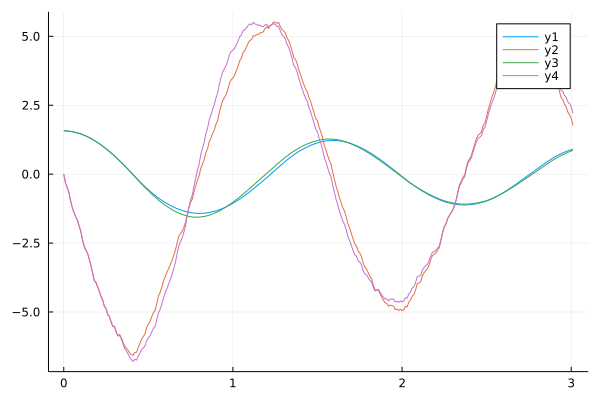

In [25]:
plot(time, theta_sim)
plot!(time, omega_sim)

plot!(time, theta_bilinear)
plot!(time, omega_bilinear)

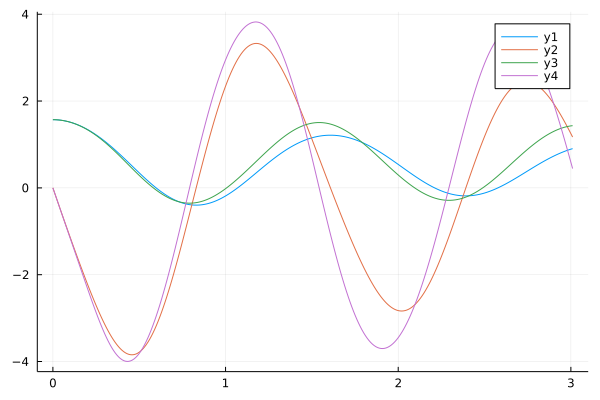

In [26]:
U_test = create_U(num_knots, m, "constant")

time_test, X_test = simulate(dmodel, x0, U_test, dt)
X_test_mat = mapreduce(permutedims, vcat, X_test)'

bi_X_test, _ = simulate_bilinear(F, C, g, x0, z0, U_test)
bi_X_test_mat = mapreduce(permutedims, vcat, bi_X_test)'

# extract individual state histories
theta_test_sim = X_test_mat[1, :]
omega_test_sim = X_test_mat[2, :]

theta_test_bilinear = bi_X_test_mat[1, :]
omega_test_bilinear = bi_X_test_mat[2, :]

plot(time_test, theta_test_sim)
plot!(time_test, omega_test_sim)

plot!(time_test, theta_test_bilinear)
plot!(time_test, omega_test_bilinear)

In [29]:
using FileIO, JLD2

FileIO.save("../../data/pendulum_eDMD_data.jld2", "F", F, "C", C, "g", g, "X_sim", X_sim, "U_sim", U_sim)